# LIGO summer 2016 workbook

Missy McIntosh

# 2016-05-25 20:19:35, New terms & toy problem

___

New Terms: 

- **ringdown** : longish-duration, small bandwidth waveform

- **matched filter analysis**

- **chirp mass**

- **Kerr configuration**

- **wave deforms length slightly, returning light is out of phase**

- **resonant optical cavity**

- **signal recycling mirror**: ?

___
Toy Problem:

- make sine gauss
- add gauss white noise w/ rand
- run mcmc have it tell me freq of the sine wave within it, and amplitude, width, time of peak

minimal uncertainty wavelengths gabor uncertainty

duration is width of peak

width of peak in frequency space = 1/ delta time

generate templates by stepping through parameter space

data * template in time domain and freqency domain

* more noise at low and high frequencies, colored noise,

divide by noise spectrum , optimal match fitting

time off = destructive interference, small product
freq wrong, etc, small number

peaked is best, but noise will screw results up
___

- **Sine-Gaussian waves** : sine wave signals modulated by a Gaussian envelope. These are characterized by the signal's central frequency and the ratio of central frequency to bandwidth (quality factor).

Well, ok. Here's a sine wave: 

$$y(t) = A\sin(2 \pi f t + \varphi) = A\sin(\omega t + \varphi)$$
where:

$A$ = the amplitude, the peak deviation of the function from zero.
$f$ = the ordinary frequency, the number of oscillations (cycles) that occur each second of time.
$\omega$ = $2\pi f$, the angular frequency, the rate of change of the function argument in units of radians per second
$\varphi$ = the phase, specifies (in radians) where in its cycle the oscillation is at $t = 0$.
When $\varphi$ is non-zero, the entire waveform appears to be shifted in time by the amount $\varphi/\omega$ seconds. A negative value represents a delay, and a positive value represents an advance.


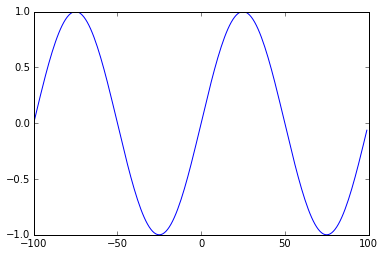

In [132]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_sine(amplitude,freq, sample_rate=100, phase=0):
    t = np.arange(-sample_rate,sample_rate)
    sinusoid = [amplitude*np.sin(2*np.pi*freq* (i/sample_rate)+ phase)  for i in t]
    return(t,sinusoid)

t,y = gen_sine(1,1)
plt.plot(t,y)
plt.show()

What's a sine-gaussian? Isn't that just like a wavepacket? 

Oh, look, Alan has a webpage on this stuff: https://labcit.ligo.caltech.edu/~ajw/bursts/burstsim.html

Which is conveniently depreciated. 

So it seems that Sine-Gaussian waves are of no astrophysical significance but can be used for "'swept-sine' calibration of our burst detection capability."

The waveforms that we are really interested in, those that might be from GW bursts are: 
- longish-duration, small bandwidth (ringdowns)
- longish-duration, large bandwidth (chirps)
- short duration, large bandwidth (merger)
- In-between (Zwerger-Muller or Dimmelmeier SN waveforms)

Anyway, the waveforms are:
- characterized by their frequency band, duration, and peak or root-sum-square amplitude
- in units of strain (that is, unitless)

And here's his Sine-Gaussian:
- h(t) = h0*exp(-(t-0.5).^2/tau^2).*sin(2*pi*f0*t); 
- My apologies for the historical use of tau instead of sigma_t = tau/sqrt(2).
- Peak amplitude h0 = 1.
- f0 = [100, 153, 235, 361, 554, 850, 1304, 2000]
- tau = 2/f0 (Q = sqrt(2)*pi*f0*tau = 8.88) or 
- tau = 2/3/f0 (Q = sqrt(2)*pi*f0*tau = 2.96)
- So, 8 central frequencies and 2 Q values = 16 waveforms

Okay, so it looks like: 

$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{\tau^2}} \sin(2\pi f_0 t) $$

or
$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{(2\sigma_t^2 )}} \sin(2\pi f_0 t) $$

but I think using $\sigma_t$ is preferred because it makes the Q-value, $Q=\sqrt{2}\pi f_0 \tau$, into $Q=2\pi f_0 \sigma_t$.

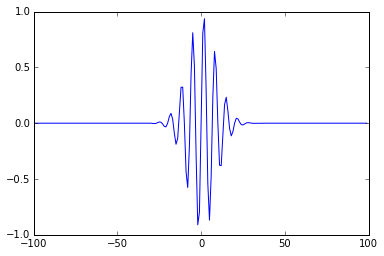

In [139]:
def gen_gaussian(t, sigma_t):
    gauss = [np.exp(-(i-0.5)**2/(2*sigma_t**2)) for i in t]
    return(t,gauss)
    
def gen_sinegauss(amplitude,freq, sigma_t, sample_rate=100, phase=0):
    t, sine = gen_sine(amplitude,freq,sample_rate, phase)
    t, gauss = gen_gaussian(t, sigma_t)
    sinegauss = [s*g for s,g in zip(sine, gauss)]
    return(t,sinegauss)

freq = 15
q = 800
sigma_t = q/(2*np.pi*freq)


t, sinegauss = gen_sinegauss(1,freq,sigma_t)
plt.plot(t,sinegauss)
plt.show()

Now for the white noise. 
- **white noise** : a random signal with a constant power spectral density;  a sequence of serially uncorrelated random variables with zero mean and finite variance; must be i.i.d.

Is drawing from random uniform ok? 

In [169]:
white_noise = np.random.uniform(-10,10,len(t))
np.var(white_noise)

32.899823734346917

Well. That isn't infinite. 

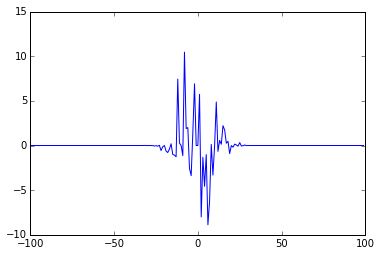

In [168]:
noisy_sinegauss = [s*n for s,n in zip(sinegauss, white_noise)]
plt.plot(t,noisy_sinegauss)
plt.show()

# 2016-05-26 07:33:57, Skyped Craig 

We went over control loop algebra and calibration and he gave me an ipython notebook for a toy problem he worked out.

This is the DARM (digital arm) spectrum: 

<img src="./figures/noise.png" style="width:700px;height:500px;">

and the quantum fluctuation/shot noise dominates at high frequencies, the seismic vibration (things like cars driving by) at low

<img src="./figures/block_diagram.png" style="width:700px;height:500px;"> 
Figure from \cite{abbott2016b}. 

We call the incoming signal $h(f) - a(f)$. 

\begin{align}
e(f) = & (h(f)-a(f))C(f)\\ 
-a(f) = & e(f)D(f)A(f)
\end{align}

combinded, we find:
    
\begin{align}
e(f) = & (h(f) - e(f)D(f)A(f))C(f) \\
e(f) = & h(f)C(f) - e(f)D(f)A(f)C(f) \\
e(f)(1+D(f)A(f)C(f)) = & h(f)C(f) \\
h(f) = & \frac{1+A(f)C(f)D(f)}{C(f)} e(f) \\
h(f) = & \frac{1 + G(f)}{C(f)} e(f)
\end{align}

where $G(f)$ is the open loop transfer function


here's his toy problem: 

https://gist.github.com/ccahilla/9b9738deb0bcf55155d2aba0058492c5
    
and he also said he would send me a code written by a grad student named Hill that has to do tracing errors in parameters that make up the $h(f) - a(f)$ signal

# 2016-06-16 10:16:30, Starting Literature Review

I'm reading \cite{abbott2016b} and \cite{Feedback2005}:

https://dcc.ligo.org/public/0122/P1500248/010/P1500248_EarlyaLIGOCalUncertainty.pdf
 
    
http://fraden.brandeis.edu/courses/phys39/Thermal%20Control/PID/Bechhoefer%20Feedback%20for%20physicists%20Rev%20Mod%20Phys%202005.pdf
    

# 2016-06-16 14:03:31 Toy Problem take #2

In [175]:
#Based off of Craig's code: https://gist.github.com/ccahilla/9b9738deb0bcf55155d2aba0058492c5
np.random.seed(123456789)   # repeatable results

def complex_sine_gaussian(central_time, central_freq, amplitude, phase, decay, time):
    return amplitude * np.exp(- decay * np.square(time - central_time)) * np.exp(1j*(2*np.pi*central_freq*(time - central_time) + phase))


So it looks like the equation for a complex sine Gaussian is: 

$$
Ae^{-d(t-t_c)^2}e^{2\pi f_c (t-t_c) + \phi}
$$

So maybe he used Euler's formula and rearranged?


\begin{aligned}e^{ix}&=\cos x+i\sin x\;\\e^{-ix}&=\cos(-x)+i\sin(-x)=\cos x-i\sin x\;\end{aligned}


$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{(2\sigma_t^2 )}} \sin(2\pi f_0 t) $$

Actually, I'm not sure. I will ask about that. 

The other change is to generate the white noise from a normal instead of uniform and to add instead of multiply it

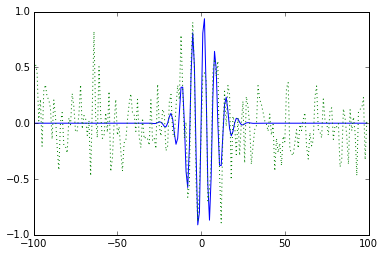

In [176]:
def gen_gaussian(t, sigma_t):
    gauss = [np.exp(-(i-0.5)**2/(2*sigma_t**2)) for i in t]
    return(t,gauss)
    
def gen_sinegauss(amplitude,freq, sigma_t, sample_rate=100, phase=0):
    t, sine = gen_sine(amplitude,freq,sample_rate, phase)
    t, gauss = gen_gaussian(t, sigma_t)
    sinegauss = [s*g for s,g in zip(sine, gauss)]
    return(t,sinegauss)

freq = 15
q = 800
sigma_t = q/(2*np.pi*freq)


t, sinegauss = gen_sinegauss(1,freq,sigma_t)
plt.plot(t,sinegauss)


white_noise = np.random.normal(0,0.25,len(t))
np.var(white_noise)

noisy_sinegauss = sinegauss+white_noise
plt.plot(t,noisy_sinegauss, ':')
plt.show()

In [177]:
# Slightly modified Craig's code:
Amp_signal = np.sqrt(np.mean(np.square(noisy_sinegauss)));
Amp_noise  = np.sqrt(np.mean(np.square(white_noise)));
SNR = np.square(Amp_signal/Amp_noise)
print('RMS Amplitude of the signal = ', Amp_signal)
print( 'RMS Amplitude of the noise = ', Amp_noise)
print( 'SNR = ', SNR)

RMS Amplitude of the signal =  0.286445655586
RMS Amplitude of the noise =  0.229769980285
SNR =  1.55416779626


Okay. Now time for the MCMC part. 

MCMCs are a way to generate statistical samples from probability distributions when integrating the probability distribution is too hard. They are a class of algorithms of which Metropolis-Hastings is the most popular (I think) but I use Goodman & Weare's algorithm in the emcee python package. 

burn in info:
http://users.stat.umn.edu/~geyer/mcmc/burn.html


In [ ]:
# Craig's code again:
# Define Log Likelihood

uncs = noise_std * np.ones(len(t))  # Uniform uncertainty in each point
def lnprob(theta, t, signal, uncs) :
    tc = theta[0]
    fc = theta[1]
    amplitude = theta[2]
    phase = theta[3]
    a = theta[4]
    
#     a = b * fc**2
    if (tc < t[0] or t[-1] < tc or fc <= 0 or fc >= 0.5/(t[1]-t[0]) or 
        amplitude <= 0 or amplitude > 5.0 or phase < -np.pi or phase >= np.pi or a <= 0 or a > 150.0):
        return -np.inf
    else :
        new_signal = np.real(complex_sine_gaussian(tc, fc, amplitude, phase, a, t));
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

# 2016-06-20 12:10:07 Lit and links



This paragraph from \cite{abbott2016b} seems to have information pertinent to my project purpose: 

"Though not yet the dominant source of error, based on the
expected sensitivity improvement of Advanced LIGO [32], calibration
uncertainties may limit astrophysical measurements
in future observing runs. In the coming era of numerous detections
of gravitational waves from diverse sources, accurate
estimation of source populations and properties will depend
critically on the accuracy of the calibrated detector outputs of
the advanced detector network. In the future, the calibration
physical model and its uncertainty will be directly employed
in the astrophysical parameter estimation procedure, which
will reduce the impact of this uncertainty on the estimation
of source parameters. We will continue to improve on the
calibration accuracy and precision reported here, with the goal
of ensuring that future astrophysical results are not limited by
calibration uncertainties as the detector sensitivity improves
and new sources are observed."

I was looking through http://www.ligo.org/ and I found these cool things: 

https://www.youtube.com/watch?v=KwbXxzgAObU

https://www.youtube.com/watch?v=3pK5oenm5gw

http://www.ligo.org/multimedia/gallery/opt.php

https://www.ligo.caltech.edu/gallery

http://www.gwoptics.org/

http://epo.sonoma.edu/EposChronicles/?p=3623&lang=en

https://www.youtube.com/channel/UCMATJmzibndbcdY8s9Prhjg

less interesting

http://www.amnh.org/sciencebulletins/content/a.f.gravity.20041101/assets/115/

http://www.amnh.org/sciencebulletins/content/a.f.gravity.20041101/assets/114/

http://spaceplace.nasa.gov/ligo-g-waves/en/

Videos:
"LIGO: A passion for understanding"
"LIGO Generations"

I also found some digital signal processing stuff and looked up info on Binder

# 2016-06-24 09:47:18 Playing with parameter modeling code

In [291]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
%matplotlib inline
#notebook
plt.rc('text', usetex=False)
plt.rcParams['mathtext.default']='regular'
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["font.size"] = 14.0

infiles = glob.glob('../data/*')
print(infiles)

['../data/summary_statistics_neff1000k.dat', '../data/summary_statistics_neff1000m.dat', '../data/summary_statistics_neff2000.dat', '../data/summary_statistics_neff2500.dat', '../data/summary_statistics_neff500.dat', '../data/summary_statistics_neff5000k.dat', '../data/summary_statistics_neff500m0.dat', '../data/summary_statistics_neff500m1.dat']


Parameter list from /home/kent/lsc/master/bin/cbcBayesPostProc.py
massParams=['mtotal','m1','m2','mc']
    distParams=['distance','distMPC','dist']
    incParams=['iota','inclination','theta_jn']
    polParams=['psi','polarisation','polarization']
    skyParams=['ra','rightascension','declination','dec']
    timeParams=['time']
    spinParams=['spin1','spin2','a1','a2','a1z','a2z','phi1','theta1','phi2','theta2',
    'chi','effectivespin','chi_eff','chi_tot','chi_p','beta','tilt1','tilt2','phi_jl','theta_jn','phi12']
    sourceParams=['m1_source','m2_source','mtotal_source','mc_source','redshift']
intrinsicParams=massParams+spinParams
    extrinsicParams=incParams+distParams+polParams+skyParams
    sourceFrameParams=sourceParams+distParams

In [292]:

df = pd.read_csv(infiles[0], sep='\t')
df.columns = df.columns.str.replace('Unnamed: 0','name')
print(df.name.values)
parameters = ['redshift','distance', 'mtotal', 'mc','matched_filter_snr', 'ra', 'dec', 'q', 'eta','psi','cosiota']
statistics = df.columns.values[1:-3]
statistics = [s for s in statistics if s != 'KL']

['theta2' 'theta1' 'chain' 'redshift' 'v1_end_time' 'flow' 'f_ref'
 'psdscaleflag' 'phi_jl' 'l1_optimal_snr' 'mtotal' 'logll1'
 'signalmodelflag' 'logl' 'phi1' 'costilt1' 'costilt2' 'h1_cplx_snr_arg'
 'm1_source' 'sky_frame' 'mc_source' 'deltalogl' 'h1_cplx_snr_amp'
 'l1v1_delay' 'mf_source' 'l1h1_delay' 'eta' 'm1' 'ra'
 'h1l1_relative_phase' 'm2' 'e_rad' 'lal_pnorder' 'v1h1_delay' 'iota'
 'm2_source' 'phi2' 'v1l1_delay' 'psi' 'cosiota' 'l1_end_time' 'phi12'
 'costheta_jn' 'a2z' 'time' 'cosbeta' 'loglh1' 'chi_tot' 'a1' 'beta' 'a2'
 'af' 'chi_p' 'optimal_snr' 'alpha' 'post' 'a1z' 'cycle' 'distance' 'mf'
 'l_peak' 'h1l1_delay' 'mc' 'l1_cplx_snr_amp' 'h1v1_delay' 'logprior'
 'theta_jn' 'phi_orb' 'l1_cplx_snr_arg' 't0' 'chi_eff' 'tilt2'
 'mtotal_source' 'h1_end_time' 'tilt1' 'lal_approximant' 'q'
 'h1_optimal_snr' 'azimuth' 'lal_amporder' 'dec' 'matched_filter_snr']


In [310]:

def plotparams(parameter, statistic, ax, log=False):
    
    neffs = []
    values = []
    people = []
    for file in infiles: 
        neff = file.split('neff')[1].split(".dat")[0]
        
        try:
            neff = float(neff)
            person = 'm'
        except:
            try:
                person = neff[-1]
                neff = float(neff[:-1])
            except:
                person = neff[-2]
                neff = float(neff[:-2])
            
        df = pd.read_csv(file, sep='\t')
        value = df.loc[df['Unnamed: 0'] == (parameter)][statistic].values[0]
        neffs.append(neff)
        values.append(value)
        people.append(person)
    try:
        #fig = plt.figure(figsize=(10,5))
        #ax = fig.add_subplot(111)
        colordict = {'m':'r', 'k':'b'}
        plt.title('{0}'.format(statistic, parameter))
        if log:
            for i in np.arange(len(values)):
                plt.scatter(np.log10(values[i]), np.log10(neffs[i]), color=colordict[people[i]], label=people[i])
            plt.xlabel(r'$log_{10}$'+'{0}'.format(parameter))
            plt.ylabel(r'$log_{10}n_{eff}$')
        else:
            for i in np.arange(len(values)):
                plt.scatter(values[i], neffs[i], color=colordict[people[i]], label=people[i])
            plt.xlabel('{0}'.format(parameter))
            plt.ylabel(r'$n_{eff}$')
            
        handles, labels = ax.get_legend_handles_labels()
        display = (0,1)
        
        #ax.legend([handle for i,handle in enumerate(handles) if i in display],
        #      ['kent', 'missy'])
        #plt.show()
              
    except:
        print('issue with {0}, {1}'.format(parameter, statistic))

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


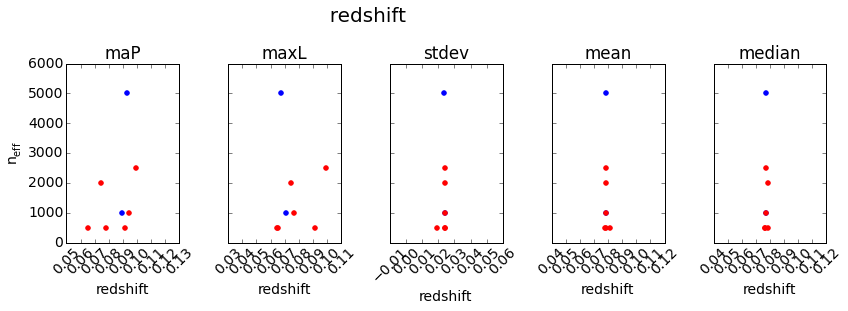

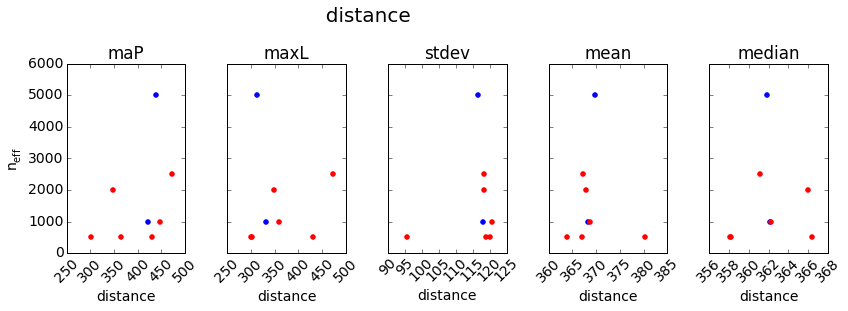

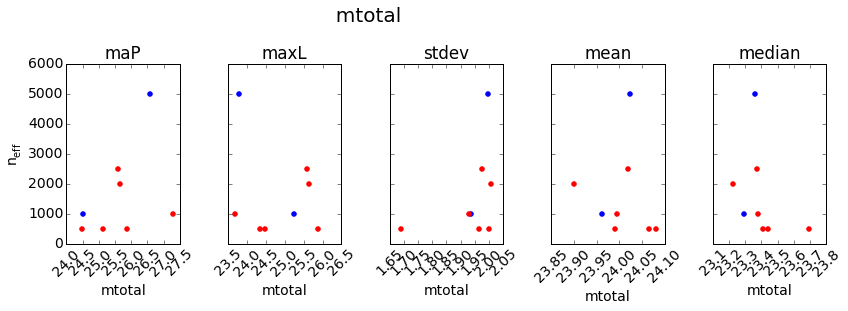

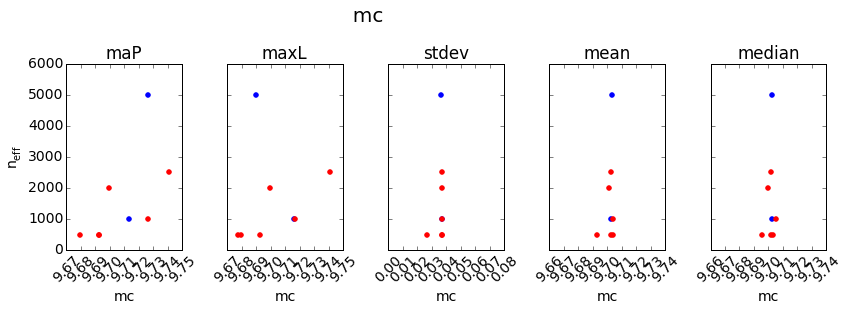

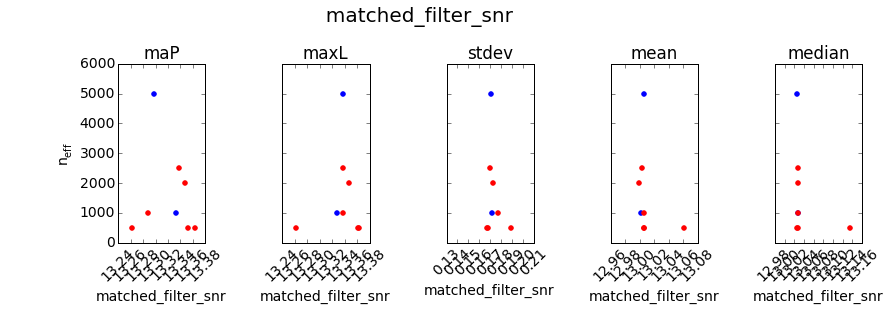

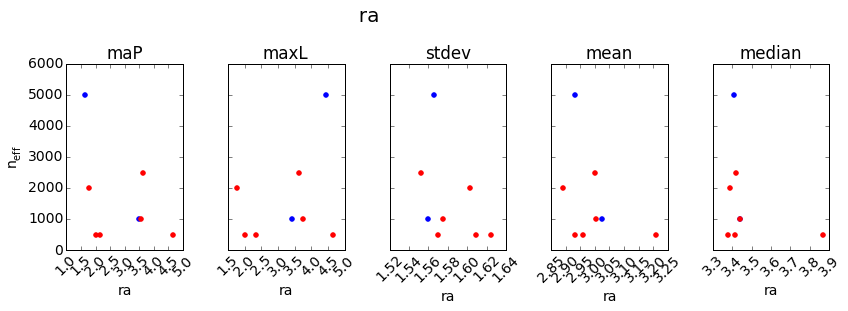

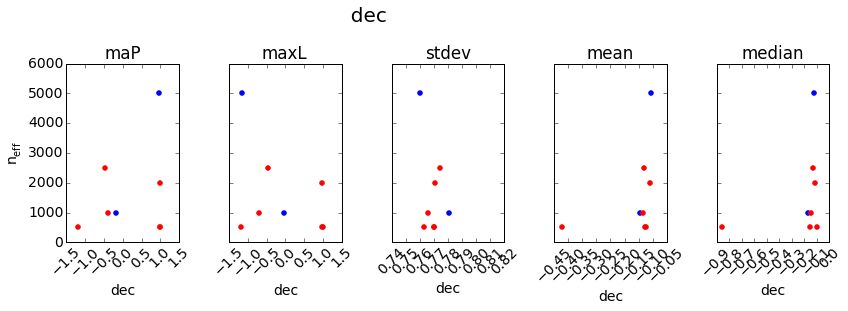

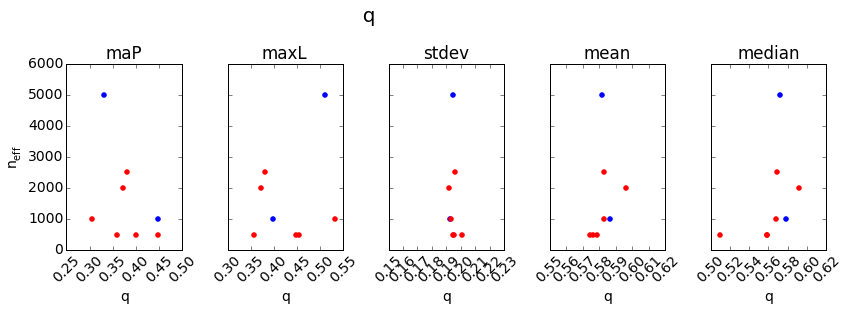

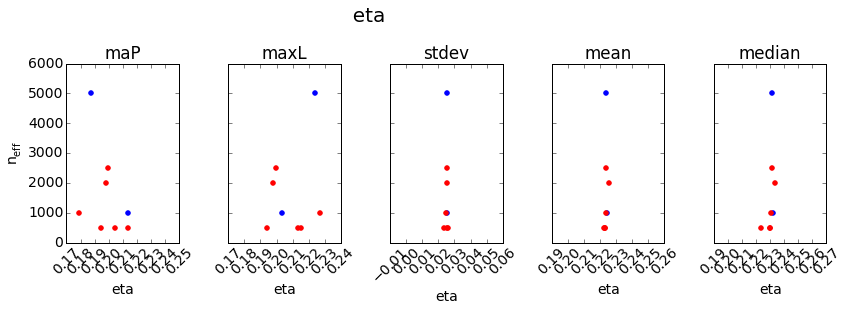

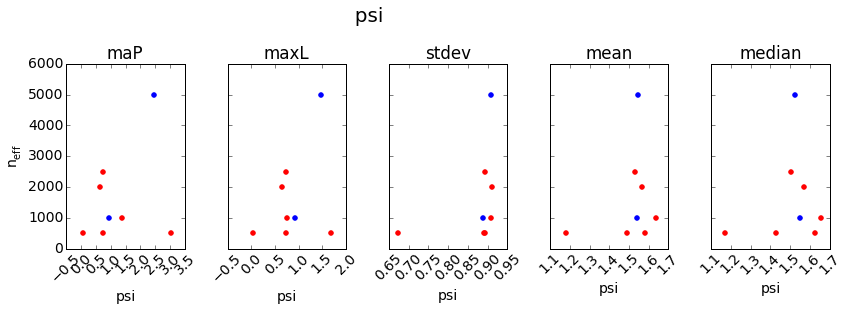

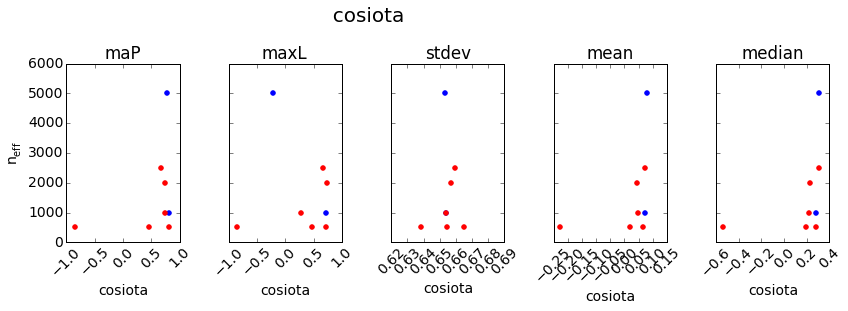

In [313]:
for parameter in parameters:
        fig = plt.figure()
        fig.suptitle(' '*50+'{0}'.format(parameter), size=20, y=1.08)
        gs = gridspec.GridSpec(1, len(statistics))
        gs.update(wspace=0.001)
        for i,statistic in enumerate(statistics): 
            if i == 0: 
                ax = plt.subplot(gs[0, i])
            else:
                ax = plt.subplot(gs[0, i], sharey=ax)
                plt.setp(ax.get_yticklabels(), visible=False)
                plt.setp(ax.yaxis.get_label(), visible=False)
            plotparams(parameter, statistic, ax)
            plt.setp(ax.get_xticklabels(), rotation=45)

        gs.tight_layout(fig, rect=[0, 0, 2, 1])
        plt.show()


In [315]:
matplotlib.pyplot.close("all")

# 2016-06-27 09:06:19  More papers

Here's some reference having to do with the actual LIGO instrument

http://adsabs.harvard.edu/abs/1995OptL...20.1507R
http://adsabs.harvard.edu/abs/1995OptL...20.1507R
http://www.sciencedirect.com/science/article/pii/037596019390620F
http://www.sciencedirect.com/science/article/pii/037596019390620F

And then Allen gave me a few on testing GR:
https://dcc.ligo.org/public/0122/P1500213/031/paper.pdf
https://dcc.ligo.org/public/0122/P1500218/014/PhysRevLett.116.241102.pdf
https://dcc.ligo.org/public/0124/P1600088/016/bbh-o1.pdf

and TIGER:
http://arxiv.org/pdf/1311.0420v2.pdf

Alan said he would rather me not go into depth about the code/how mcmc works but just say what they do